## Supervised Learning
## Project: Finding Donors for *CharityML*

## Getting Started

In this project, I will employ several supervised algorithms of my choice to accurately model individuals' income using data collected from the 1994 U.S. Census. I will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. My goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf).


----
## Exploring the Data
The last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Importing supplementary visualization code visuals.py
!ln -s ../input/visuals/visuals.py visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Loading the Census dataset
data = pd.read_csv("../input/census/census.csv")

# Success - Displaying the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, I will compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`. 

In [2]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = data[data['income'] == '>50K'].shape[0]

# Number of records where individual's income is at most $50,000
n_at_most_50k = data[data['income'] == '<=50K'].shape[0]

# Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k / n_records) * 100

# Printing the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data

### Transforming Skewed Continuous Features

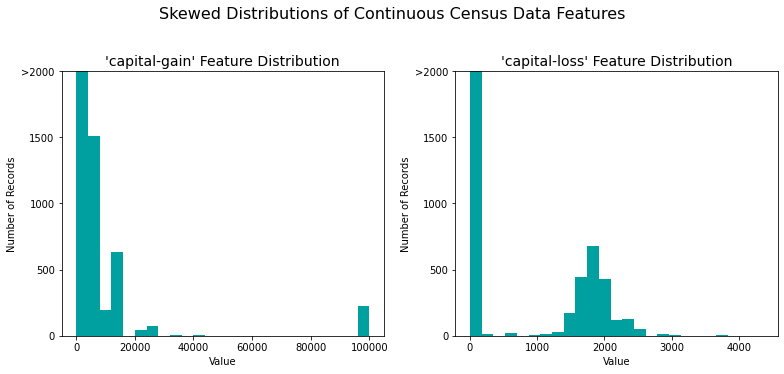

In [3]:
# Splitting the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualizing skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

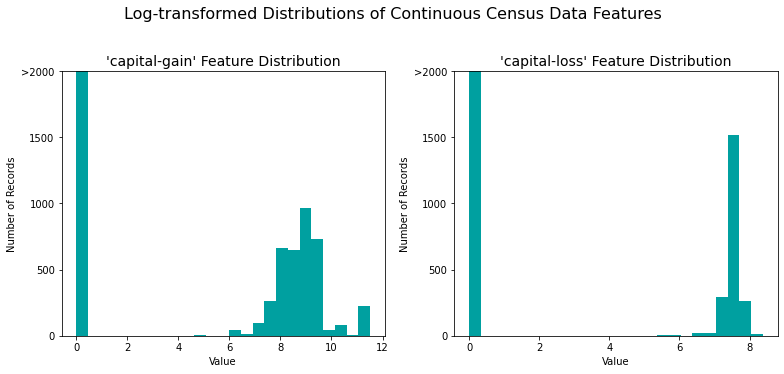

In [4]:
# Log-transforming the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualizing the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features

In [5]:
# Importing sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initializing a scaler, then applying it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Showing an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Data Preprocessing

In [6]:
# One-hot encoding the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encoding the 'income_raw' data to numerical values
income = income_raw.replace({'<=50K': 0, '>50K': 1})

# Printing the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

print(encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
We will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [7]:
# Importing train_test_split
from sklearn.model_selection import train_test_split

# Splitting the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Showing the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision.

### Naive Predictor Performace

In [8]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# Calculating accuracy, precision and recall
accuracy = np.sum(income) / income.count()
recall = np.sum(income) / (np.sum(income) + 0)
precision = np.sum(income) / (np.sum(income) + (income.count() - np.sum(income)))

# Calculating F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = ((1 + 0.5 ** 2) * (precision * recall)) / (0.5 ** 2 * precision + recall)

# Printing the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


### Model Application

**Models I'm going to use, and some info about each one:**

1) Logistic Regression

- Real-world Application:  
A credit card company wants to know whether transaction amount and credit score impact the probability of a given transaction being fraudulent. To understand the relationship between these two predictor variables and the probability of a transaction being fraudulent, the company can perform logistic regression.


- Strengths:  
1- Logistic regression is easy to implement, interpret, and very efficient to train.  
2- It makes no assumptions about distributions of classes in feature space.  
3- It is very fast at classifying unknown records.  
- When does it perform well?  
When the dataset is linearly separable.



- Weaknesses:  
1- It constructs linear boundaries.  
2- The assumption of linearity between the dependent variable and the independent variables.  
3- It is tough to obtain complex relationships using logistic regression.  
- When does it perform poorly?  
When the number of observations is lesser than the number of features.


- This model is a good candidate for our problem because our dataset is simple & our dependant variable is binary in nature (0/1).


2) Gaussian Naive Bayes

- Real-world Application:  
Classifying SMS messages as spam or not. To detect the probability of an SMS text being spam, many companies use Gaussian Naive Bayes, where it performs well in text classification problems.


- Strengths:  
1- Easy and quick way to predict classes, both in binary and multiclass classification problems.  
2- In the cases that the independence assumption fits, the algorithm performs better compared to other classification models, even with less training data.  
3- The decoupling of the class conditional feature distributions means that each distribution can be independently estimated as a one dimensional distribution. This helps with problems derived from the curse of dimensionality and improve the performance.  
- When does it perform well?  
When the features of the data are independent.



- Weaknesses:  
1- The naive assumption of independence is very unlikely to match real-world data.  
2- When the test data set has a feature that has not been observed in the training set, the model will assign a 0 probability to it and will be useless to make predictions.   
- When does it perform poorly?  
When there exist strong depedencies between features.


- This model is a good candidate for our problem because most of our variables seem independent.

3) Random Forest

- Real-world Application:  
Detecting Parkinson-related lesions within the midbrain in 3D transcranial ultrasound. Where the random forest model uses the organ arrangement, size, shape and the leaf nodes predict the organ class and spatial location.


- Strengths:  
1- It works well with both categorical and continuous values.  
2- It reduces overfitting in decision trees and helps to improve the accuracy.
3- It automates missing values present in the data.
- When does it perform well?  
Random Forest's efficiency is particularly Notable in Large Data sets.



- Weaknesses:  
1- It requires much computational power as well as resources as it builds numerous trees to combine their outputs.  
2- It also requires much time for training as it combines a lot of decision trees to determine the class.  
3- Due to the ensemble of decision trees, it also suffers interpretability and fails to determine the significance of each variable.  
- When does it perform poorly?  
When interpretable model information is crucial.


- This model is a good candidate for our problem because we have a big dataset (45k+ samples & 100+ features).


>References:  
https://www.geeksforgeeks.org/advantages-and-disadvantages-of-logistic-regression/   
https://www.statology.org/logistic-regression-real-life-examples/   
https://towardsdatascience.com/naive-bayes-intuition-and-implementation-ac328f9c9718   
https://www.mygreatlearning.com/blog/random-forest-algorithm/   


### Creating a Training and Predicting Pipeline

In [9]:
# Importing two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fitting the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculating the training time
    results['train_time'] = end - start
        
    # Getting the predictions on the test set(X_test),
    # then getting predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculating the total prediction time
    results['pred_time'] = end - start
            
    # Computing accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(predictions_train, y_train[:300])
        
    # Computing accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(predictions_test, y_test)
    
    # Computing F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(predictions_train, y_train[:300], beta=1)
        
    # Computing F-score on the test set which is y_test
    results['f_test'] = fbeta_score(predictions_test, y_test, beta=1)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Returning the results
    return results

### Initial Model Evaluation

LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.


/kaggle/working/visuals.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


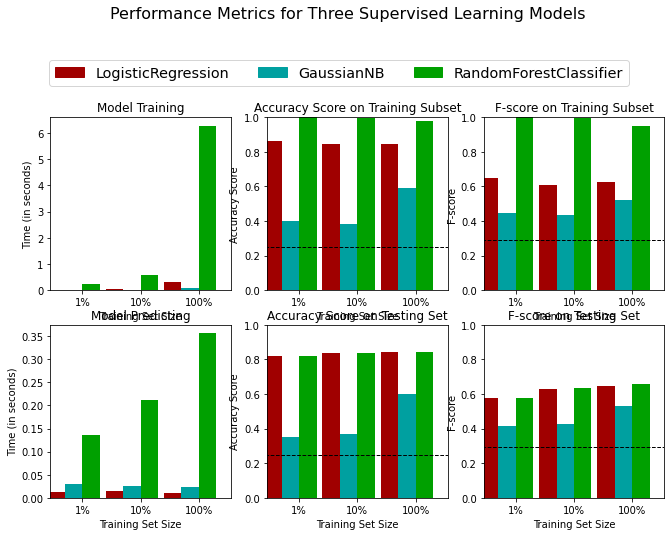

In [10]:
# Importing the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# Initializing the three models
clf_A = LogisticRegression(solver='liblinear')
clf_B = GaussianNB()
clf_C = RandomForestClassifier()

# Calculating the number of samples for 1%, 10%, and 100% of the training data
# samples_100 is the entire training set i.e. len(y_train)
# samples_10 is 10% of samples_100
# samples_1 is 1% of samples_100
samples_100 = len(y_train)
samples_10 = int(0.1 * samples_100)
samples_1 = int(0.01 * samples_100)

# Collecting results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Running metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, I will choose from the three supervised learning models the *best* model to use on the student data. I will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Choosing the Best Model

Looking into the F-score on the testing set when all of the training data is used, we can clearly see nearly equal F-scores for both our Logistic Regression & Random Forest models (0.7), while our Gaussian Naive Bayes model had a significantly less F-score (~0.5). Moreover, the training time for our Random Forest model was nearly double the training time for the Logistic Regression model in all the sample sizes we used (1%, 10%, and 100%), with the Gaussian Naive Bayes model having the least training time in all of them. Furthermore, the prediction time for our Random Forest model was the highest for both the 10% & 100% samples, with the Gaussian Naive Bayes model having the highest prediction time for the 1% sample, and the Logistic Regression model having the least prediction time in all samples.


Although our Logistic Regression & Random Forest models had the same F-scores, we believe the Logistic Regression model to be the most appropriate for the task of identifying individuals that make more than $50,000, and that's due to it being faster than the Random Forest model in both training & predicting, the clear over-fitting occuring in the the Random Forest model, the algorithm's suitability for our data that is sparse & simple, and its big interpretability in comparison to the Random Forest model.

### Describing the Model in Layman's Terms

Our Logistic Regression model is a mathematical model used in statistics to estimate (guess) the probability of an event occurring having been given some previous data. Logistic regression works with binary data, where either the event happens (1) or the event does not happen (0) (simple wikipedia), so either the individual is making making more than 50k (1) or is not (0).


The logistic regression model is trained on our data by trying to find an equation that accurately predicts the probablility of an individual making making more than 50k based on our features, where the model uses the 'income' feature to keep modifying the predicting equation until it comes out with the most precise equation with the least prediction errors. If the probablility is >= 0.5 than the model outputs (1) predicting that the individual is making more than 50k, while if the probablility is < 0.5 than the model outputs (0) predicting that the individual is making less than or equal to 50k.

### Model Tuning

In [11]:
# Importing 'GridSearchCV' and 'make_scorer'
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Initializing the classifier
clf = LogisticRegression(solver='liblinear')

# Creating the parameters list we wish to tune, using a dictionary if needed.
# parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'C': np.logspace(-4, 4, 50)}

# Making an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=1)

# Performing grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fitting the grid search object to the training data and finding the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Getting the estimator
best_clf = grid_fit.best_estimator_

# Making predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Reporting the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8419
F-score on testing data: 0.6832

Optimized Model
------
Final accuracy score on the testing data: 0.8416
Final F-score on the testing data: 0.6823


### Final Model Evaluation

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |    0.8419         | 0.8418          |
| F-score        |   0.6832          |     0.6828      |


Our Accuracy Score & F-score for our optimized model are slighly less than for our unoptimized model, which indicates the small role regulization plays in our model for the task of identifying individuals that make more than 50k. However, the results of our optimized model are way higher than the naive predictor benchmarks we found earlier (0.84 & 0.68 vs 0.25 & 0.29), which indicate the huge role our model plays in identifying individuals that make more than $50,000.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

### Feature Relevance Logical Observation

- Thinking logically, I would say age, capital gain, marital-status, hours-per-week, and sex are the most important features for prediction .

- I would rank age as the most important one, as I think there is an age range where individuals will have a very high chance of earning more than 50k (senior employees), next is capital gain, due to the high possible correlation between it & the income, then the marital-status, due to civilian spouses having a high probablity of a high income in comparison spouces in the armed forces & single individuals, then hours-per-week, due to the chance of a correlation between number of hours worked and income, and finally sex, where I think male individuals might have a higher change of a high income.

### Extracting Feature Importance

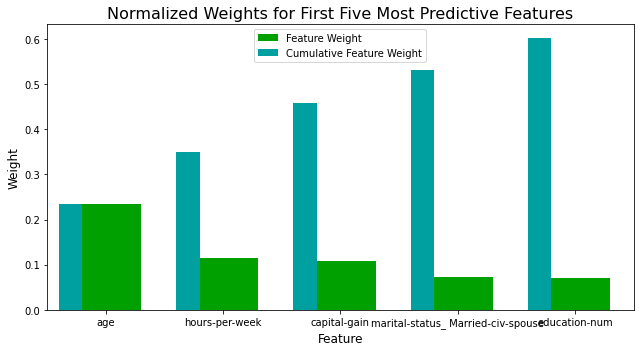

In [12]:
# Importing a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import RandomForestClassifier

# Training the supervised model on the training set using .fit(X_train, y_train)
model = RandomForestClassifier().fit(X_train, y_train)

# Extracting the feature importances using .feature_importances_ 
importances = model.feature_importances_ 

# Plot
vs.feature_plot(importances, X_train, y_train)

### Extracting Feature Importance

The most important feature for prediction turned out to be age as I predicted. The next most important one turned out to be hours-per-week, where I actually predicted it to be the fifth one, where the number of working hours seems to heavily effect one's income more than I thought. The third one is capital-gain which I predicted to be the second but due to the hours-per-week being more significant than I expected it turned out to be third. The fourth one is education-num which I totally missed, I knew there was an obivous potential relationship between education-num and income but I thought it wasn't strong enough to be in the top 5 however education-num actually seems significant in predicting one's income. Lastly, we have status_Married-civ-spouse which I correctly predicted the concept of (civilian spouse vs other) but missed out on the correct ranking. And finally, my male bias seems to be totaly wrong XD.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn.

In [13]:
# Importing functionality for cloning a model
from sklearn.base import clone

# Reducing the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Trainning on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Making new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Reporting scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8416
F-score on testing data: 0.6823

Final Model trained on reduced data
------
Accuracy on testing data: 0.8266
F-score on testing data: 0.6480


### Effects of Feature Selection

- The accuracy score when using five features only was slightly less than when we used the full data (by 2%), while the F-score was less by about double that amount (~4%).

- Conclusion: I wouldn't sacrifice ~0.04 F-score for less training time, as more training time can be dealed with more than the overhead costs of sending more emails to individuals that certainly won't donate.